## **Study Objectives**

An A/B test was conducted to analyze the performance of a new checkout funnel that includes an improved recommendation system.
The main goal of this study is to evaluate whether these changes improve user conversion across the different stages of the funnel:

    -Login
    -Viewing a product page (product_page)
    -Adding an item to the cart (product_cart)
    -Completing a purchase (purchase)

It is expected that, within 14 days after registration, users in the new funnel (Group B) will show at least a 10% increase at each stage compared to the control group (Group A).

Additionally, before analyzing the results, we will verify that the experiment was conducted correctly, ensuring that the data is valid, the groups are properly defined, and there are no inconsistencies that could affect the conclusions of the test.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
from statsmodels.stats.proportion import proportions_ztest

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')

In [3]:
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [7]:
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], format = '%Y-%m-%d')
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], format = '%Y-%m-%d')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [8]:
users['first_date'] = pd.to_datetime(users['first_date'], format = '%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [9]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format = '%Y-%m-%d %H:%M:%S')
events['date'] = events['event_dt'].dt.date
events['time'] = events['event_dt'].dt.time
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
 4   date        423761 non-null  object        
 5   time        423761 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 19.4+ MB


In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [11]:
print('Marketing duplicates: ', marketing.duplicated().sum())
print('Users duplicates: ', users.duplicated().sum())
print('Events duplicates: ', events.duplicated().sum())
print('Participants duplicates: ', participants.duplicated().sum())

Marketing duplicates:  0
Users duplicates:  0
Events duplicates:  0
Participants duplicates:  0


In [12]:
group_a = set(participants[participants['group'] == 'A']['user_id'].unique())
group_b = set(participants[participants['group'] == 'B']['user_id'].unique())

users_in_both = group_a.intersection(group_b)

print(f"Users in both groups: {len(users_in_both)}")

Users in both groups: 441


In [13]:
participants = participants[~participants['user_id'].isin(users_in_both)]
users = users[~users['user_id'].isin(users_in_both)]
events = events[~events['user_id'].isin(users_in_both)]

### Users in both groups
We removed the data of users who were in both groups so that it would not affect the test results.

In [14]:
users_participants = pd.merge(
    users,         
    participants,      
    on='user_id',      
    how='inner')

users_participants = users_participants[users_participants['region'] == 'EU']
users_participants.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test


In [15]:
users_participants = users_participants[
    (users_participants['first_date'] >= '2020-12-07') &
    (users_participants['first_date'] <= '2021-01-01')]
users_participants.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
4,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test


In [16]:
valid_users = users[
    (users['first_date'] >= '2020-12-07') &
    (users['first_date'] <= '2021-01-01')]

users_participants = pd.merge(
    valid_users[['user_id', 'first_date', 'region']],
    participants,
    on='user_id',
    how='inner')

users_participants = users_participants[users_participants['region'] == 'EU']

events = pd.merge(events, users_participants[['user_id', 'first_date']], on='user_id', how='inner')
events = events[(events['event_dt'] - events['first_date']).dt.days <= 14]


In [17]:
events_per_user = (events.groupby('user_id')['event_name']
    .count().reset_index()
    .rename(columns={'event_name': 'event_count'}))
events_per_user.head()

,user_id,event_count
0,0002CE61FF2C4011,12
1,001064FEAAB631A1,12
2,0010A1C096941592,12
3,001E72F50D1C48FA,6
4,002412F1EB3F6E38,6


In [18]:
users_participants = pd.merge(users_participants, events_per_user, on= 'user_id')
users_participants.head()

,user_id,first_date,region,group,ab_test,event_count
0,D72A72121175D8BE,2020-12-07,EU,A,recommender_system_test,2
1,2E1BF1D4C37EA01F,2020-12-07,EU,A,interface_eu_test,9
2,50734A22C0C63768,2020-12-07,EU,B,interface_eu_test,9
3,5BE017E9C8CC42F8,2020-12-07,EU,B,interface_eu_test,4
4,96F27A054B191457,2020-12-07,EU,B,interface_eu_test,9


In [19]:
users_participants.groupby('group')['event_count'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,7629.0,7.618954,4.735524,1.0,4.0,6.0,10.0,40.0
B,5818.0,7.064971,4.262357,1.0,4.0,6.0,9.0,36.0


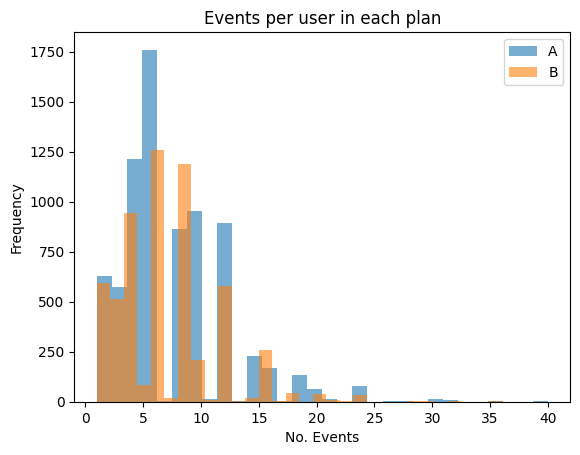

In [20]:
users_participants[users_participants['group'] == 'A']['event_count'].plot(kind='hist', bins=30, alpha=0.6, label='A')  
users_participants[users_participants['group'] == 'B']['event_count'].plot(kind='hist', bins=30, alpha=0.6, label='B')  
plt.title('Events per user in each plan')  
plt.xlabel('No. Events')  
plt.legend() 
plt.show() 

### Number of events distribution
The distribution of the number of events per user is very balanced between groups A and B. There appears to be no behavioral bias (One group does not have significantly more active users than the other).

In [21]:
events = (pd.merge(events, users_participants, on= 'user_id')
    .drop(['ab_test', 'event_count'], axis='columns'))
events.head()

,user_id,event_dt,event_name,details,date,time,first_date_x,first_date_y,region,group
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,04:02:40,2020-12-07,2020-12-07,EU,B
1,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-08,09:43:14,2020-12-07,2020-12-07,EU,B
2,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-09,00:44:10,2020-12-07,2020-12-07,EU,B
3,96F27A054B191457,2020-12-07 04:02:41,product_page,NaN,2020-12-07,04:02:41,2020-12-07,2020-12-07,EU,B
4,96F27A054B191457,2020-12-08 09:43:18,product_page,NaN,2020-12-08,09:43:18,2020-12-07,2020-12-07,EU,B


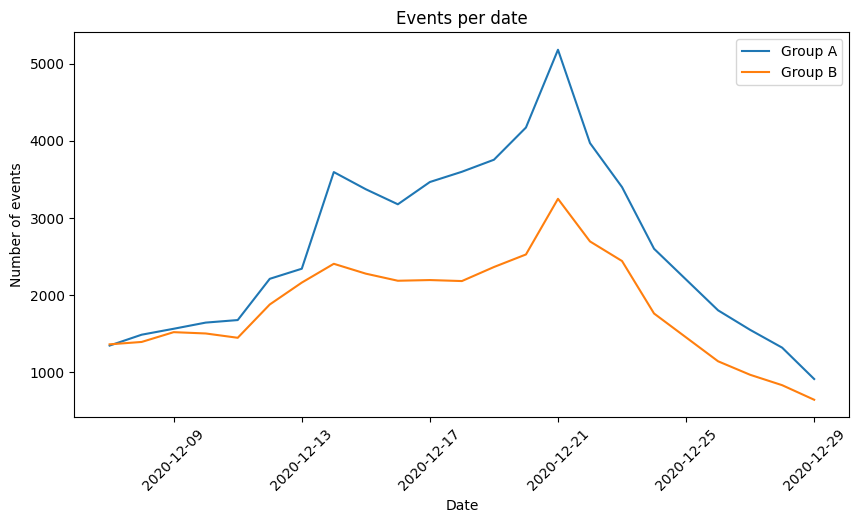

In [22]:
events_a = events[events['group'] == 'A']
events_a = events_a.groupby('date')['event_name'].count()

events_b = events[events['group'] == 'B'] 
events_b = events_b.groupby('date')['event_name'].count()

fig, ax = plt.subplots(figsize=(10,5)) 
events_a.plot(ax=ax, label='Group A')
events_b.plot(ax=ax, label='Group B')  
plt.title('Events per date')   
plt.xlabel('Date')  
plt.ylabel('Number of events')
plt.legend() 
plt.xticks(rotation=45)
plt.show() 

### Events in time
Both groups show a similar line, which tells us that there were no external biases.

In [23]:
events['event_name'].unique()

array(['purchase', 'product_page', 'login', 'product_cart'], dtype=object)

In [24]:
funnel = (events.groupby(['group', 'event_name'])['user_id']
    .nunique()
    .unstack())
funnel = funnel[['login', 'product_page', 'product_cart', 'purchase']]
funnel

event_name,login,product_page,product_cart,purchase
group,,,,
A,7288,4841,2315,2516
B,5711,3684,1900,1874


In [25]:
funnel['login_to_page'] = funnel['product_page'] / funnel['login'] * 100
funnel['page_to_cart'] = funnel['product_cart'] / funnel['product_page'] * 100
funnel['cart_to_purchase'] = funnel['purchase'] / funnel['product_cart'] * 100
funnel['page_to_purchase'] = funnel['purchase'] / funnel['product_page'] * 100

funnel = funnel.round(2)
funnel

event_name,login,product_page,product_cart,purchase,login_to_page,page_to_cart,cart_to_purchase,page_to_purchase
group,,,,,,,,
A,7288,4841,2315,2516,66.42,47.82,108.68,51.97
B,5711,3684,1900,1874,64.51,51.57,98.63,50.87


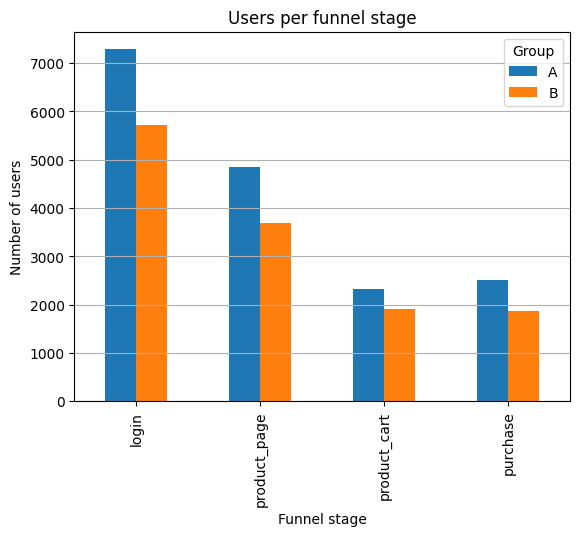

In [26]:
funnel[['login', 'product_page', 'product_cart', 'purchase']].T.plot(kind='bar')
plt.title('Users per funnel stage')
plt.ylabel('Number of users')
plt.xlabel('Funnel stage')
plt.legend(title='Group')
plt.grid(axis='y')
plt.show()

### Note on data inconsistency:
In Group A, the number of purchases exceeds the number of users who added items to the cart, resulting in a conversion rate greater than 100%.
This suggests that some users may have completed a purchase without generating a product_cart event, possibly due to:

    - a direct purchase flow from the product page
    - incomplete event tracking

In [27]:
mask = (
    marketing['regions'].str.contains('EU') &
    (marketing['start_dt'] <= '2021-01-01') &
    (marketing['finish_dt'] >= '2020-12-07')
)
print('''This campaign could be a potential source of bias for the test, 
as it was conducted during the same period and in the same region as the test.''')
marketing[mask]

This campaign could be a potential source of bias for the test, 
as it was conducted during the same period and in the same region as the test.


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


In [28]:
users_participants.head()

,user_id,first_date,region,group,ab_test,event_count
0,D72A72121175D8BE,2020-12-07,EU,A,recommender_system_test,2
1,2E1BF1D4C37EA01F,2020-12-07,EU,A,interface_eu_test,9
2,50734A22C0C63768,2020-12-07,EU,B,interface_eu_test,9
3,5BE017E9C8CC42F8,2020-12-07,EU,B,interface_eu_test,4
4,96F27A054B191457,2020-12-07,EU,B,interface_eu_test,9


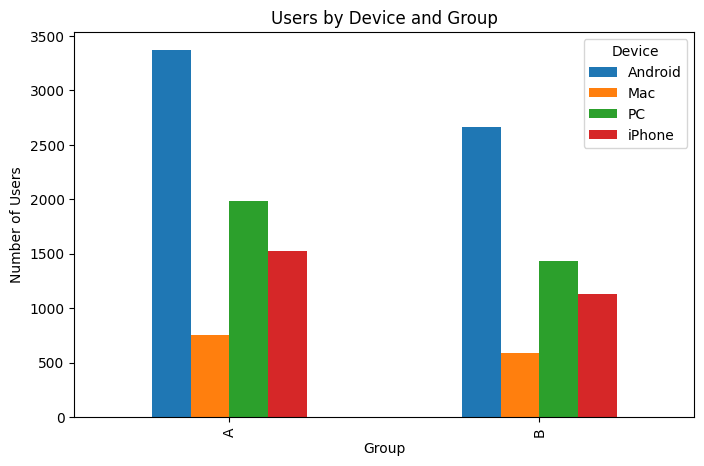

In [29]:
users_participants = pd.merge(users_participants, users, on= 'user_id')

device_group = users_participants.groupby(['group', 'device'])['user_id'].count().unstack()
device_group.plot(kind='bar', figsize=(8,5))
plt.title('Users by Device and Group')
plt.xlabel('Group')
plt.ylabel('Number of Users')
plt.legend(title='Device')
plt.show()

The distribution across devices is very similar in both groups, so it's not something we can consider bias.

In [30]:
stages = [
  ('product_page', 'login', 'login_to_page'),
  ('product_cart', 'product_page', 'page_to_cart'),
  ('purchase', 'product_cart', 'cart_to_purchase'),
  ('purchase', 'product_page', 'page_to_purchase')
]


results = []

for success, total, name in stages:
    successes = [funnel.loc['A', success], funnel.loc['B', success]]
    nobs = [funnel.loc['A', total], funnel.loc['B', total]]
    
    z_stat, p_val = proportions_ztest(successes, nobs)
    results.append({
        'Conversion': name,
        'Group A %': round(successes[0] / nobs[0] * 100, 2),
        'Group B %': round(successes[1] / nobs[1] * 100, 2),
        'Z-Score': round(z_stat, 3),
        'P-Value': round(p_val, 4),
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

results_df = pd.DataFrame(results)
results_df

/.venv/lib/python3.9/site-packages/statsmodels/stats/proportion.py:859: RuntimeWarning: invalid value encountered in sqrt
  std_diff = np.sqrt(var_)


,Conversion,Group A %,Group B %,Z-Score,P-Value,Significant
0,login_to_page,66.42,64.51,2.283,0.0224,Yes
1,page_to_cart,47.82,51.57,-3.434,0.0006,Yes
2,cart_to_purchase,108.68,98.63,NaN,NaN,No
3,page_to_purchase,51.97,50.87,1.010,0.3123,No


### Conclusion

Based on the results, the new interface (Group B) improved the intermediate conversion rate from product_page to product_cart, which could indicate better user engagement and retention. However, it did not lead to a higher final purchase rate, the main goal of the funnel. Therefore, there is not enough evidence to justify implementing the new funnel permanently.

It is recommended to review the event tracking system, particularly the product_cart → purchase stage, and to conduct a new controlled experiment ensuring a complete and consistent data flow.